In [10]:
import sys

from torchvision import transforms
import numpy as np
import torch
from pytorch3d.renderer import rasterize_meshes
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from PIL import Image
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

if ".." not in sys.path:
    sys.path.append("..")
    
from datasets.NYUDataset import NYUDataset
from model.MeshTransform import MeshTransform
from model.Skeleton import Skeleton
from model.HandModel import HandModel
from utils.general import load_mesh_data, load_skeleton
from utils.util import batched_index_select

In [11]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points[0].clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, y, z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    ax.view_init(-90, 90)
    plt.show()
    
def plot_hands3d(ax, points, color, linewidth='3'):
    # Add bone connections
    bones = [(0, 1),
             (1, 2),
             (2, 3),
             (3, 4),
             (0, 21),
             (21, 5),
             (5, 6),
             (6, 7),
             (7, 8),
             (21, 9),
             (9, 10),
             (10, 11),
             (11, 12),
             (21, 13),
             (13, 14),
             (14, 15),
             (15, 16),
             (21, 17),
             (17, 18),
             (18, 19),
             (19, 20)]

    for connection in bones:
        coord1 = points[connection[0]]
        coord2 = points[connection[1]]
        coords = np.stack([coord1, coord2])
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], c=color, linewidth=linewidth)
        
def plot_hands2d(ax, points, color, linewidth='3'):
    # Add bone connections
    bones = [(0, 1),
             (1, 2),
             (2, 3),
             (3, 4),
             (0, 21),
             (21, 5),
             (5, 6),
             (6, 7),
             (7, 8),
             (21, 9),
             (9, 10),
             (10, 11),
             (11, 12),
             (21, 13),
             (13, 14),
             (14, 15),
             (15, 16),
             (21, 17),
             (17, 18),
             (18, 19),
             (19, 20)]

    for connection in bones:
        coord1 = points[connection[0]]
        coord2 = points[connection[1]]
        coords = np.stack([coord1, coord2])
        ax.plot(coords[:, 0], coords[:, 1], c=color, linewidth=linewidth)

In [12]:
# Hand Model & Mesh Transform
skeleton_path = "/home/alex/dev/projects/libhand-public/nyu_synth/ogre/hand.skeleton.xml"
mesh_path = "/home/alex/dev/projects/libhand-public/nyu_synth/ogre/hand.mesh.xml"

rotations, positions, hand_parent_idxs = load_skeleton(skeleton_path)
rotations = torch.from_numpy(rotations).to(torch.float32).cuda()
positions = torch.from_numpy(positions).to(torch.float32).cuda()
skeleton = Skeleton(hand_parent_idxs)

# Camera and project matrices
proj_matrix = torch.Tensor([[1.732051, 0.0, 0.0, 0.0],
                            [0.0, 1.732051, 0.0, 0.0],
                            [0.0, 0.0, 1.025316, -0.202532],
                            [0.0, 0.0, 0.0, 1.0]])
view_matrix = torch.Tensor([[1.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 1.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

clip_space_matrix = view_matrix @ proj_matrix
clip_space_matrix = clip_space_matrix.to(torch.cuda.current_device())

# Initialize HandModel
trainable_idxs = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20]
hand_model = HandModel(positions, rotations, skeleton, trainable_idxs)

# Initialize MeshTransform
T = skeleton.to_matrix(rotations.unsqueeze(0),
                       positions.unsqueeze(0),
                       torch.ones(1, rotations.shape[0], 3,
                                  device=torch.cuda.current_device()))
T_inv = np.linalg.inv(T.cpu().numpy())
verts, normals, bone_weights, faces = load_mesh_data(mesh_path)

mesh_transform = MeshTransform(
    np.concatenate((verts, np.ones((verts.shape[0], 1))), axis=1),
    np.concatenate((normals, np.ones((normals.shape[0], 1))), axis=1),
    T_inv,
    bone_weights,
    clip_space_matrix)
mesh_transform.cuda()

MeshTransform()

In [13]:
def calc_scale(kps):
    min_vals, _ = kps.min(1)
    max_vals, _ = kps.max(1)
    diff = (max_vals - min_vals)
    return diff


def normalize_depth(depth_img):
    """Normalize depth image to be in range [-1, 1]."""
    bg_mask = (depth_img == -1)
    fg_mask = (depth_img > -1)
    min_val = depth_img[fg_mask].min()
    max_val = depth_img[fg_mask].max()
    depth_img[fg_mask] -= min_val
    depth_img[fg_mask] /= (max_val - min_val)
    depth_img[fg_mask] *= 2.0
    depth_img[fg_mask] -= 1.0
    depth_img[bg_mask] = 1.0

    return depth_img


def forward(x, clip_space_matrix):
    joint_idxs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 6]
    local_transforms, coord_pred, rot_offset = hand_model(x)
    mesh, _ = mesh_transform(local_transforms)

    coord_affine = torch.cat((coord_pred,
                              torch.ones(coord_pred.shape[0], coord_pred.shape[1], 1, device=torch.device('cuda'))), 2)
    mesh = mesh @ clip_space_matrix.to(torch.cuda.current_device())
    mesh = mesh[:, :, :3] / mesh[:, :, 3, None]
    coord_affine = coord_affine @ clip_space_matrix.to(torch.cuda.current_device())
    coord_affine = coord_affine[:, :, :3] / coord_affine[:, :, 3, None]

    min_vals, _ = coord_affine[:, joint_idxs].min(1)
    max_vals, _ = coord_affine[:, joint_idxs].max(1)
    center = (max_vals + min_vals) / 2
    diff, _ = (max_vals - min_vals).max(1)
    
    mesh -= center.unsqueeze(1)
    mesh *= ((2 / diff.unsqueeze(1).unsqueeze(1).repeat(1, mesh.shape[1], 3)) * 0.75)
    mesh[:, :, 2] += 1

    coord_affine -= center.unsqueeze(1)
    coord_affine *= ((2 / diff.unsqueeze(1).unsqueeze(1).repeat(1, coord_affine.shape[1], 3)) * 0.75)
    coord_affine[:, :, 2] += 1
    
    # Initialize Meshes
    meshes = Meshes(mesh, faces.unsqueeze(0).repeat(mesh.shape[0], 1, 1))
    
    # Rasterize
    _, zbuf, _, _ = rasterize_meshes(meshes.cuda(), image_size=224, cull_backfaces=True)
    
    # Crop
    out_img = zbuf[:, :, :, 0]
    
    return out_img, coord_affine, mesh

In [14]:
# NYU Dataset
data_path = "/home/alex/Data/nyu/dataset/train"
tsfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224, Image.NEAREST),
    transforms.ToTensor()
])
nyu_dataset = NYUDataset(data_path, tsfm, tsfm, [], synth=True)

<IPython.core.display.Javascript object>


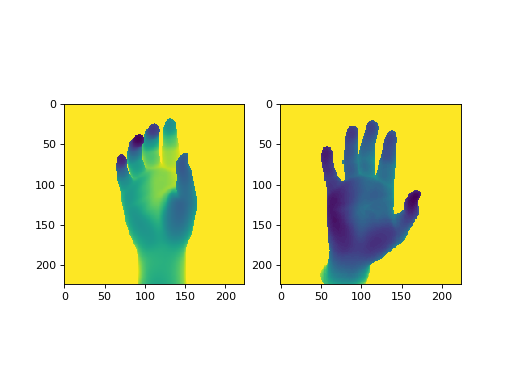

In [15]:
joint_idxs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 6]


x = torch.zeros(8, 17, 4, device=torch.device('cuda'))
x[:, :, 0] = 1
x[:, 0, 2] = 1
x[:, 0, 0] = 0
out_img, c, m = forward(x, clip_space_matrix)
cviz = c[0, joint_idxs].cpu()
mviz = m[0].cpu()

# viewport transform
# image_size = 224
# coord_px = coord_affine[:, joint_idxs].clone()
# min_vals, _ = coord_px.min(1)
# max_vals, _ = coord_px.max(1)
# diff, _ = (max_vals - min_vals).max(1)
# diff = diff.unsqueeze(1).unsqueeze(1).repeat(1, coord_px.shape[1], 3)
# coord_px *= (2 / diff)
# coord_px[:, :, 0] *= -1
# coord_px[:, :, 0] = (coord_px[:, :, 0] + 1) * 0.5 * image_size
# coord_px[:, :, 1] = (1 - (coord_px[:, :, 1] + 1) * 0.5) * image_size

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(mviz[:, 0], mviz[:, 1], mviz[:, 2], alpha=0.01)
# plot_hands3d(ax, cviz, 'r')

img = normalize_depth(out_img[0])
# img = out_img[0]

sample, _, _, _, _, _, _, _, _ = nyu_dataset[0]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(img.cpu())
# plot_hands2d(ax1, coord_px[0].cpu(), 'r')
ax2 = fig.add_subplot(122)
ax2.imshow(sample[0])